In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : [],
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_0_t1t2_normalized_e_e_e_1_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(466039, 919)
(466039, 1)
validation
(80707, 919)
(80707, 1)
test
(46831, 919)
(46831, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 919)]             0         


 dense (Dense)               (None, 1024)              942080    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1631233 (6.22 MB)


Trainable params: 1631233 (6.22 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/47 [..............................] - ETA: 1:11 - loss: 0.0737 - STD: 1.8750e-04 - MAE: 0.2521

 4/47 [=>............................] - ETA: 1s - loss: 0.0322 - STD: 2.8955e-04 - MAE: 0.1393  

 7/47 [===>..........................] - ETA: 0s - loss: 0.0309 - STD: 2.2751e-04 - MAE: 0.1366

10/47 [=====>........................] - ETA: 0s - loss: 0.0297 - STD: 1.8961e-04 - MAE: 0.1329

12/47 [======>.......................] - ETA: 0s - loss: 0.0281 - STD: 1.7507e-04 - MAE: 0.1279

15/47 [========>.....................] - ETA: 0s - loss: 0.0252 - STD: 1.6437e-04 - MAE: 0.1198

18/47 [==========>...................] - ETA: 0s - loss: 0.0235 - STD: 1.6089e-04 - MAE: 0.1170

21/47 [============>.................] - ETA: 0s - loss: 0.0225 - STD: 1.6113e-04 - MAE: 0.1158

24/47 [==============>...............] - ETA: 0s - loss: 0.0213 - STD: 1.6392e-04 - MAE: 0.1127

27/47 [================>.............] - ETA: 0s - loss: 0.0204 - STD: 1.6653e-04 - MAE: 0.1098

28/47 [================>.............] - ETA: 1s - loss: 0.0203 - STD: 1.6749e-04 - MAE: 0.1089

31/47 [==================>...........] - ETA: 0s - loss: 0.0196 - STD: 1.7104e-04 - MAE: 0.1067

34/47 [====================>.........] - ETA: 0s - loss: 0.0190 - STD: 1.7703e-04 - MAE: 0.1048

37/47 [======================>.......] - ETA: 0s - loss: 0.0185 - STD: 1.8530e-04 - MAE: 0.1035

40/47 [========================>.....] - ETA: 0s - loss: 0.0181 - STD: 1.9518e-04 - MAE: 0.1026

42/47 [=========================>....] - ETA: 0s - loss: 0.0179 - STD: 2.0215e-04 - MAE: 0.1021

45/47 [===========================>..] - ETA: 0s - loss: 0.0175 - STD: 2.1259e-04 - MAE: 0.1012

47/47 [==============================] - 4s 57ms/step - loss: 0.0173 - STD: 2.1947e-04 - MAE: 0.1006 - val_loss: 0.0114 - val_STD: 3.2594e-04 - val_MAE: 0.0787


Epoch 2/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0124 - STD: 3.8323e-04 - MAE: 0.0845

 4/47 [=>............................] - ETA: 1s - loss: 0.0126 - STD: 4.0442e-04 - MAE: 0.0854

 7/47 [===>..........................] - ETA: 0s - loss: 0.0126 - STD: 4.2988e-04 - MAE: 0.0857

10/47 [=====>........................] - ETA: 0s - loss: 0.0126 - STD: 4.5970e-04 - MAE: 0.0863

13/47 [=======>......................] - ETA: 0s - loss: 0.0126 - STD: 4.9152e-04 - MAE: 0.0870

16/47 [=========>....................] - ETA: 0s - loss: 0.0126 - STD: 5.2312e-04 - MAE: 0.0873

19/47 [===========>..................] - ETA: 0s - loss: 0.0126 - STD: 5.5451e-04 - MAE: 0.0872

22/47 [=============>................] - ETA: 0s - loss: 0.0126 - STD: 5.8774e-04 - MAE: 0.0870

25/47 [==============>...............] - ETA: 0s - loss: 0.0126 - STD: 6.2649e-04 - MAE: 0.0870

28/47 [================>.............] - ETA: 0s - loss: 0.0126 - STD: 6.7106e-04 - MAE: 0.0871

31/47 [==================>...........] - ETA: 0s - loss: 0.0126 - STD: 7.2213e-04 - MAE: 0.0872

34/47 [====================>.........] - ETA: 0s - loss: 0.0126 - STD: 7.7898e-04 - MAE: 0.0873

37/47 [======================>.......] - ETA: 0s - loss: 0.0126 - STD: 8.4187e-04 - MAE: 0.0872

40/47 [========================>.....] - ETA: 0s - loss: 0.0126 - STD: 9.1244e-04 - MAE: 0.0871

43/47 [==========================>...] - ETA: 0s - loss: 0.0125 - STD: 9.9445e-04 - MAE: 0.0870

46/47 [============================>.] - ETA: 0s - loss: 0.0125 - STD: 0.0011 - MAE: 0.0870    

47/47 [==============================] - 1s 28ms/step - loss: 0.0125 - STD: 0.0011 - MAE: 0.0870 - val_loss: 0.0112 - val_STD: 0.0025 - val_MAE: 0.0800


Epoch 3/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0127 - STD: 0.0030 - MAE: 0.0884

 4/47 [=>............................] - ETA: 1s - loss: 0.0124 - STD: 0.0032 - MAE: 0.0874

 7/47 [===>..........................] - ETA: 0s - loss: 0.0123 - STD: 0.0036 - MAE: 0.0868

10/47 [=====>........................] - ETA: 0s - loss: 0.0123 - STD: 0.0039 - MAE: 0.0865

13/47 [=======>......................] - ETA: 0s - loss: 0.0122 - STD: 0.0044 - MAE: 0.0863

16/47 [=========>....................] - ETA: 0s - loss: 0.0121 - STD: 0.0049 - MAE: 0.0862

19/47 [===========>..................] - ETA: 0s - loss: 0.0121 - STD: 0.0056 - MAE: 0.0862

21/47 [============>.................] - ETA: 0s - loss: 0.0121 - STD: 0.0060 - MAE: 0.0860

23/47 [=============>................] - ETA: 0s - loss: 0.0120 - STD: 0.0066 - MAE: 0.0858

26/47 [===============>..............] - ETA: 0s - loss: 0.0119 - STD: 0.0075 - MAE: 0.0856

29/47 [=================>............] - ETA: 0s - loss: 0.0118 - STD: 0.0086 - MAE: 0.0852

32/47 [===================>..........] - ETA: 0s - loss: 0.0117 - STD: 0.0098 - MAE: 0.0849

34/47 [====================>.........] - ETA: 0s - loss: 0.0117 - STD: 0.0106 - MAE: 0.0847

37/47 [======================>.......] - ETA: 0s - loss: 0.0116 - STD: 0.0121 - MAE: 0.0844

40/47 [========================>.....] - ETA: 0s - loss: 0.0115 - STD: 0.0136 - MAE: 0.0840

43/47 [==========================>...] - ETA: 0s - loss: 0.0114 - STD: 0.0152 - MAE: 0.0836

46/47 [============================>.] - ETA: 0s - loss: 0.0113 - STD: 0.0169 - MAE: 0.0833

47/47 [==============================] - 1s 29ms/step - loss: 0.0113 - STD: 0.0175 - MAE: 0.0832 - val_loss: 0.0088 - val_STD: 0.0368 - val_MAE: 0.0709


Epoch 4/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0097 - STD: 0.0440 - MAE: 0.0769

 4/47 [=>............................] - ETA: 1s - loss: 0.0098 - STD: 0.0449 - MAE: 0.0775

 7/47 [===>..........................] - ETA: 0s - loss: 0.0098 - STD: 0.0458 - MAE: 0.0771

10/47 [=====>........................] - ETA: 0s - loss: 0.0097 - STD: 0.0465 - MAE: 0.0768

13/47 [=======>......................] - ETA: 0s - loss: 0.0096 - STD: 0.0470 - MAE: 0.0764

16/47 [=========>....................] - ETA: 0s - loss: 0.0096 - STD: 0.0474 - MAE: 0.0760

19/47 [===========>..................] - ETA: 0s - loss: 0.0095 - STD: 0.0478 - MAE: 0.0756

22/47 [=============>................] - ETA: 0s - loss: 0.0094 - STD: 0.0483 - MAE: 0.0753

25/47 [==============>...............] - ETA: 0s - loss: 0.0093 - STD: 0.0488 - MAE: 0.0749

27/47 [================>.............] - ETA: 0s - loss: 0.0093 - STD: 0.0492 - MAE: 0.0746

30/47 [==================>...........] - ETA: 0s - loss: 0.0092 - STD: 0.0499 - MAE: 0.0742

33/47 [====================>.........] - ETA: 0s - loss: 0.0091 - STD: 0.0507 - MAE: 0.0739

36/47 [=====================>........] - ETA: 0s - loss: 0.0090 - STD: 0.0514 - MAE: 0.0735

39/47 [=======================>......] - ETA: 0s - loss: 0.0089 - STD: 0.0522 - MAE: 0.0730

42/47 [=========================>....] - ETA: 0s - loss: 0.0088 - STD: 0.0531 - MAE: 0.0726

45/47 [===========================>..] - ETA: 0s - loss: 0.0087 - STD: 0.0540 - MAE: 0.0722

47/47 [==============================] - 1s 28ms/step - loss: 0.0087 - STD: 0.0546 - MAE: 0.0719 - val_loss: 0.0073 - val_STD: 0.0635 - val_MAE: 0.0652


Epoch 5/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0076 - STD: 0.0688 - MAE: 0.0666

 4/47 [=>............................] - ETA: 1s - loss: 0.0073 - STD: 0.0679 - MAE: 0.0651

 7/47 [===>..........................] - ETA: 0s - loss: 0.0073 - STD: 0.0683 - MAE: 0.0650

10/47 [=====>........................] - ETA: 0s - loss: 0.0072 - STD: 0.0686 - MAE: 0.0648

13/47 [=======>......................] - ETA: 0s - loss: 0.0072 - STD: 0.0691 - MAE: 0.0646

16/47 [=========>....................] - ETA: 0s - loss: 0.0072 - STD: 0.0694 - MAE: 0.0642

18/47 [==========>...................] - ETA: 0s - loss: 0.0071 - STD: 0.0695 - MAE: 0.0640

21/47 [============>.................] - ETA: 0s - loss: 0.0071 - STD: 0.0699 - MAE: 0.0638

24/47 [==============>...............] - ETA: 0s - loss: 0.0071 - STD: 0.0702 - MAE: 0.0637

27/47 [================>.............] - ETA: 0s - loss: 0.0070 - STD: 0.0705 - MAE: 0.0635

30/47 [==================>...........] - ETA: 0s - loss: 0.0070 - STD: 0.0706 - MAE: 0.0632

33/47 [====================>.........] - ETA: 0s - loss: 0.0070 - STD: 0.0708 - MAE: 0.0631

36/47 [=====================>........] - ETA: 0s - loss: 0.0069 - STD: 0.0710 - MAE: 0.0629

39/47 [=======================>......] - ETA: 0s - loss: 0.0069 - STD: 0.0712 - MAE: 0.0627

42/47 [=========================>....] - ETA: 0s - loss: 0.0069 - STD: 0.0714 - MAE: 0.0626

45/47 [===========================>..] - ETA: 0s - loss: 0.0069 - STD: 0.0716 - MAE: 0.0625

47/47 [==============================] - 1s 29ms/step - loss: 0.0069 - STD: 0.0717 - MAE: 0.0624 - val_loss: 0.0070 - val_STD: 0.0714 - val_MAE: 0.0635


Epoch 6/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0067 - STD: 0.0780 - MAE: 0.0625

 4/47 [=>............................] - ETA: 1s - loss: 0.0064 - STD: 0.0760 - MAE: 0.0600

 7/47 [===>..........................] - ETA: 0s - loss: 0.0063 - STD: 0.0762 - MAE: 0.0598

10/47 [=====>........................] - ETA: 0s - loss: 0.0064 - STD: 0.0760 - MAE: 0.0598

13/47 [=======>......................] - ETA: 0s - loss: 0.0064 - STD: 0.0756 - MAE: 0.0599

16/47 [=========>....................] - ETA: 0s - loss: 0.0064 - STD: 0.0755 - MAE: 0.0598

19/47 [===========>..................] - ETA: 0s - loss: 0.0064 - STD: 0.0757 - MAE: 0.0597

22/47 [=============>................] - ETA: 0s - loss: 0.0064 - STD: 0.0757 - MAE: 0.0597

25/47 [==============>...............] - ETA: 0s - loss: 0.0064 - STD: 0.0757 - MAE: 0.0596

28/47 [================>.............] - ETA: 0s - loss: 0.0064 - STD: 0.0756 - MAE: 0.0595

31/47 [==================>...........] - ETA: 0s - loss: 0.0064 - STD: 0.0756 - MAE: 0.0594

34/47 [====================>.........] - ETA: 0s - loss: 0.0064 - STD: 0.0757 - MAE: 0.0594

37/47 [======================>.......] - ETA: 0s - loss: 0.0063 - STD: 0.0757 - MAE: 0.0592

40/47 [========================>.....] - ETA: 0s - loss: 0.0063 - STD: 0.0758 - MAE: 0.0592

43/47 [==========================>...] - ETA: 0s - loss: 0.0063 - STD: 0.0759 - MAE: 0.0591

46/47 [============================>.] - ETA: 0s - loss: 0.0063 - STD: 0.0761 - MAE: 0.0591

47/47 [==============================] - 1s 28ms/step - loss: 0.0063 - STD: 0.0762 - MAE: 0.0590 - val_loss: 0.0068 - val_STD: 0.0734 - val_MAE: 0.0619


Epoch 7/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0060 - STD: 0.0791 - MAE: 0.0580

 4/47 [=>............................] - ETA: 1s - loss: 0.0060 - STD: 0.0788 - MAE: 0.0574

 7/47 [===>..........................] - ETA: 0s - loss: 0.0060 - STD: 0.0789 - MAE: 0.0575

10/47 [=====>........................] - ETA: 0s - loss: 0.0060 - STD: 0.0789 - MAE: 0.0576

13/47 [=======>......................] - ETA: 0s - loss: 0.0061 - STD: 0.0786 - MAE: 0.0577

16/47 [=========>....................] - ETA: 0s - loss: 0.0061 - STD: 0.0784 - MAE: 0.0577

19/47 [===========>..................] - ETA: 0s - loss: 0.0061 - STD: 0.0784 - MAE: 0.0578

22/47 [=============>................] - ETA: 0s - loss: 0.0061 - STD: 0.0784 - MAE: 0.0577

25/47 [==============>...............] - ETA: 0s - loss: 0.0061 - STD: 0.0783 - MAE: 0.0576

28/47 [================>.............] - ETA: 0s - loss: 0.0061 - STD: 0.0783 - MAE: 0.0575

31/47 [==================>...........] - ETA: 0s - loss: 0.0060 - STD: 0.0782 - MAE: 0.0574

34/47 [====================>.........] - ETA: 0s - loss: 0.0060 - STD: 0.0783 - MAE: 0.0573

37/47 [======================>.......] - ETA: 0s - loss: 0.0060 - STD: 0.0784 - MAE: 0.0573

40/47 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0785 - MAE: 0.0572

43/47 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0786 - MAE: 0.0571

46/47 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0788 - MAE: 0.0571

47/47 [==============================] - 1s 28ms/step - loss: 0.0060 - STD: 0.0787 - MAE: 0.0571 - val_loss: 0.0080 - val_STD: 0.0793 - val_MAE: 0.0674


Epoch 8/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0059 - STD: 0.0850 - MAE: 0.0588

 3/47 [>.............................] - ETA: 1s - loss: 0.0059 - STD: 0.0809 - MAE: 0.0564

 6/47 [==>...........................] - ETA: 1s - loss: 0.0058 - STD: 0.0803 - MAE: 0.0561

 9/47 [====>.........................] - ETA: 0s - loss: 0.0058 - STD: 0.0799 - MAE: 0.0559

12/47 [======>.......................] - ETA: 0s - loss: 0.0058 - STD: 0.0802 - MAE: 0.0558

15/47 [========>.....................] - ETA: 0s - loss: 0.0057 - STD: 0.0806 - MAE: 0.0556

18/47 [==========>...................] - ETA: 0s - loss: 0.0057 - STD: 0.0808 - MAE: 0.0556

21/47 [============>.................] - ETA: 0s - loss: 0.0058 - STD: 0.0808 - MAE: 0.0558

24/47 [==============>...............] - ETA: 0s - loss: 0.0058 - STD: 0.0808 - MAE: 0.0560

27/47 [================>.............] - ETA: 0s - loss: 0.0059 - STD: 0.0808 - MAE: 0.0562

30/47 [==================>...........] - ETA: 0s - loss: 0.0059 - STD: 0.0808 - MAE: 0.0564

33/47 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0806 - MAE: 0.0565

36/47 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0805 - MAE: 0.0564

39/47 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0803 - MAE: 0.0563

42/47 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0801 - MAE: 0.0562

45/47 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0801 - MAE: 0.0562

47/47 [==============================] - 1s 28ms/step - loss: 0.0058 - STD: 0.0802 - MAE: 0.0562 - val_loss: 0.0066 - val_STD: 0.0732 - val_MAE: 0.0612


Epoch 9/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0055 - STD: 0.0771 - MAE: 0.0535

 4/47 [=>............................] - ETA: 1s - loss: 0.0056 - STD: 0.0799 - MAE: 0.0544

 7/47 [===>..........................] - ETA: 0s - loss: 0.0055 - STD: 0.0804 - MAE: 0.0544

10/47 [=====>........................] - ETA: 0s - loss: 0.0055 - STD: 0.0806 - MAE: 0.0545

13/47 [=======>......................] - ETA: 0s - loss: 0.0055 - STD: 0.0807 - MAE: 0.0543

16/47 [=========>....................] - ETA: 0s - loss: 0.0055 - STD: 0.0809 - MAE: 0.0542

19/47 [===========>..................] - ETA: 0s - loss: 0.0055 - STD: 0.0812 - MAE: 0.0544

22/47 [=============>................] - ETA: 0s - loss: 0.0055 - STD: 0.0813 - MAE: 0.0543

25/47 [==============>...............] - ETA: 0s - loss: 0.0055 - STD: 0.0816 - MAE: 0.0543

28/47 [================>.............] - ETA: 0s - loss: 0.0055 - STD: 0.0817 - MAE: 0.0543

31/47 [==================>...........] - ETA: 0s - loss: 0.0055 - STD: 0.0818 - MAE: 0.0542

34/47 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0820 - MAE: 0.0542

37/47 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0820 - MAE: 0.0542

40/47 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0821 - MAE: 0.0542

43/47 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0822 - MAE: 0.0542

46/47 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0822 - MAE: 0.0541

47/47 [==============================] - 1s 28ms/step - loss: 0.0055 - STD: 0.0823 - MAE: 0.0541 - val_loss: 0.0077 - val_STD: 0.0807 - val_MAE: 0.0660


Epoch 10/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0052 - STD: 0.0818 - MAE: 0.0528

 4/47 [=>............................] - ETA: 1s - loss: 0.0053 - STD: 0.0841 - MAE: 0.0532

 7/47 [===>..........................] - ETA: 0s - loss: 0.0054 - STD: 0.0844 - MAE: 0.0532

10/47 [=====>........................] - ETA: 0s - loss: 0.0054 - STD: 0.0844 - MAE: 0.0533

13/47 [=======>......................] - ETA: 0s - loss: 0.0053 - STD: 0.0844 - MAE: 0.0533

16/47 [=========>....................] - ETA: 0s - loss: 0.0054 - STD: 0.0841 - MAE: 0.0533

19/47 [===========>..................] - ETA: 0s - loss: 0.0054 - STD: 0.0842 - MAE: 0.0535

22/47 [=============>................] - ETA: 0s - loss: 0.0054 - STD: 0.0843 - MAE: 0.0534

25/47 [==============>...............] - ETA: 0s - loss: 0.0053 - STD: 0.0844 - MAE: 0.0533

28/47 [================>.............] - ETA: 0s - loss: 0.0054 - STD: 0.0842 - MAE: 0.0534

31/47 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0842 - MAE: 0.0535

34/47 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0842 - MAE: 0.0535

37/47 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0842 - MAE: 0.0536

40/47 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0841 - MAE: 0.0536

43/47 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0840 - MAE: 0.0536

46/47 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0838 - MAE: 0.0537

47/47 [==============================] - 1s 28ms/step - loss: 0.0054 - STD: 0.0839 - MAE: 0.0537 - val_loss: 0.0083 - val_STD: 0.0810 - val_MAE: 0.0688


Epoch 11/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0052 - STD: 0.0840 - MAE: 0.0530

 4/47 [=>............................] - ETA: 1s - loss: 0.0054 - STD: 0.0826 - MAE: 0.0536

 7/47 [===>..........................] - ETA: 0s - loss: 0.0054 - STD: 0.0830 - MAE: 0.0534

10/47 [=====>........................] - ETA: 0s - loss: 0.0054 - STD: 0.0836 - MAE: 0.0533

13/47 [=======>......................] - ETA: 0s - loss: 0.0053 - STD: 0.0839 - MAE: 0.0531

16/47 [=========>....................] - ETA: 0s - loss: 0.0053 - STD: 0.0842 - MAE: 0.0532

19/47 [===========>..................] - ETA: 0s - loss: 0.0053 - STD: 0.0841 - MAE: 0.0531

21/47 [============>.................] - ETA: 0s - loss: 0.0053 - STD: 0.0841 - MAE: 0.0530

24/47 [==============>...............] - ETA: 0s - loss: 0.0053 - STD: 0.0840 - MAE: 0.0529

27/47 [================>.............] - ETA: 0s - loss: 0.0053 - STD: 0.0842 - MAE: 0.0529

30/47 [==================>...........] - ETA: 0s - loss: 0.0053 - STD: 0.0843 - MAE: 0.0529

33/47 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0843 - MAE: 0.0528

36/47 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0844 - MAE: 0.0528

39/47 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0844 - MAE: 0.0527

42/47 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0845 - MAE: 0.0527

45/47 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0845 - MAE: 0.0526

47/47 [==============================] - 1s 28ms/step - loss: 0.0052 - STD: 0.0846 - MAE: 0.0526 - val_loss: 0.0093 - val_STD: 0.0862 - val_MAE: 0.0725


Epoch 12/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0051 - STD: 0.0879 - MAE: 0.0527

 4/47 [=>............................] - ETA: 0s - loss: 0.0051 - STD: 0.0860 - MAE: 0.0521

 7/47 [===>..........................] - ETA: 0s - loss: 0.0052 - STD: 0.0845 - MAE: 0.0526

10/47 [=====>........................] - ETA: 0s - loss: 0.0055 - STD: 0.0851 - MAE: 0.0542

13/47 [=======>......................] - ETA: 0s - loss: 0.0054 - STD: 0.0852 - MAE: 0.0538

15/47 [========>.....................] - ETA: 0s - loss: 0.0055 - STD: 0.0848 - MAE: 0.0539

18/47 [==========>...................] - ETA: 0s - loss: 0.0055 - STD: 0.0848 - MAE: 0.0539

21/47 [============>.................] - ETA: 0s - loss: 0.0054 - STD: 0.0846 - MAE: 0.0538

24/47 [==============>...............] - ETA: 0s - loss: 0.0054 - STD: 0.0844 - MAE: 0.0537

27/47 [================>.............] - ETA: 0s - loss: 0.0054 - STD: 0.0844 - MAE: 0.0534

30/47 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0844 - MAE: 0.0533

33/47 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0844 - MAE: 0.0532

35/47 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0845 - MAE: 0.0531

38/47 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0845 - MAE: 0.0531

41/47 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0845 - MAE: 0.0531

44/47 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0846 - MAE: 0.0530

47/47 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0846 - MAE: 0.0530

47/47 [==============================] - 1s 28ms/step - loss: 0.0053 - STD: 0.0846 - MAE: 0.0530 - val_loss: 0.0090 - val_STD: 0.0846 - val_MAE: 0.0719


Epoch 13/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0053 - STD: 0.0851 - MAE: 0.0532

 4/47 [=>............................] - ETA: 1s - loss: 0.0052 - STD: 0.0842 - MAE: 0.0522

 7/47 [===>..........................] - ETA: 0s - loss: 0.0051 - STD: 0.0845 - MAE: 0.0520

10/47 [=====>........................] - ETA: 0s - loss: 0.0052 - STD: 0.0851 - MAE: 0.0522

13/47 [=======>......................] - ETA: 0s - loss: 0.0052 - STD: 0.0853 - MAE: 0.0522

16/47 [=========>....................] - ETA: 0s - loss: 0.0052 - STD: 0.0852 - MAE: 0.0521

19/47 [===========>..................] - ETA: 0s - loss: 0.0051 - STD: 0.0853 - MAE: 0.0520

22/47 [=============>................] - ETA: 0s - loss: 0.0051 - STD: 0.0854 - MAE: 0.0519

25/47 [==============>...............] - ETA: 0s - loss: 0.0051 - STD: 0.0854 - MAE: 0.0519

28/47 [================>.............] - ETA: 0s - loss: 0.0051 - STD: 0.0856 - MAE: 0.0519

31/47 [==================>...........] - ETA: 0s - loss: 0.0051 - STD: 0.0858 - MAE: 0.0518

34/47 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.0857 - MAE: 0.0518

37/47 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0858 - MAE: 0.0517

40/47 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0859 - MAE: 0.0517

43/47 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0856 - MAE: 0.0521

46/47 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0856 - MAE: 0.0522

47/47 [==============================] - 1s 28ms/step - loss: 0.0052 - STD: 0.0858 - MAE: 0.0523 - val_loss: 0.0076 - val_STD: 0.0773 - val_MAE: 0.0672


Epoch 14/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0060 - STD: 0.0769 - MAE: 0.0536

 4/47 [=>............................] - ETA: 1s - loss: 0.0055 - STD: 0.0833 - MAE: 0.0533

 7/47 [===>..........................] - ETA: 0s - loss: 0.0056 - STD: 0.0836 - MAE: 0.0540

10/47 [=====>........................] - ETA: 0s - loss: 0.0057 - STD: 0.0834 - MAE: 0.0545

13/47 [=======>......................] - ETA: 0s - loss: 0.0058 - STD: 0.0830 - MAE: 0.0553

16/47 [=========>....................] - ETA: 0s - loss: 0.0060 - STD: 0.0826 - MAE: 0.0563

19/47 [===========>..................] - ETA: 0s - loss: 0.0060 - STD: 0.0826 - MAE: 0.0566

22/47 [=============>................] - ETA: 0s - loss: 0.0060 - STD: 0.0820 - MAE: 0.0565

25/47 [==============>...............] - ETA: 0s - loss: 0.0060 - STD: 0.0813 - MAE: 0.0562

28/47 [================>.............] - ETA: 0s - loss: 0.0059 - STD: 0.0814 - MAE: 0.0562

31/47 [==================>...........] - ETA: 0s - loss: 0.0059 - STD: 0.0813 - MAE: 0.0560

34/47 [====================>.........] - ETA: 0s - loss: 0.0058 - STD: 0.0810 - MAE: 0.0557

37/47 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0810 - MAE: 0.0555

40/47 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0812 - MAE: 0.0553

43/47 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0814 - MAE: 0.0551

46/47 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0813 - MAE: 0.0549

47/47 [==============================] - 1s 28ms/step - loss: 0.0056 - STD: 0.0814 - MAE: 0.0548 - val_loss: 0.0079 - val_STD: 0.0789 - val_MAE: 0.0677


Epoch 15/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0053 - STD: 0.0818 - MAE: 0.0522

 4/47 [=>............................] - ETA: 1s - loss: 0.0051 - STD: 0.0832 - MAE: 0.0518

 7/47 [===>..........................] - ETA: 0s - loss: 0.0051 - STD: 0.0839 - MAE: 0.0519

10/47 [=====>........................] - ETA: 0s - loss: 0.0051 - STD: 0.0841 - MAE: 0.0517

13/47 [=======>......................] - ETA: 0s - loss: 0.0051 - STD: 0.0845 - MAE: 0.0517

16/47 [=========>....................] - ETA: 0s - loss: 0.0051 - STD: 0.0847 - MAE: 0.0517

19/47 [===========>..................] - ETA: 0s - loss: 0.0051 - STD: 0.0849 - MAE: 0.0517

22/47 [=============>................] - ETA: 0s - loss: 0.0051 - STD: 0.0850 - MAE: 0.0517

25/47 [==============>...............] - ETA: 0s - loss: 0.0051 - STD: 0.0852 - MAE: 0.0516

28/47 [================>.............] - ETA: 0s - loss: 0.0051 - STD: 0.0852 - MAE: 0.0516

31/47 [==================>...........] - ETA: 0s - loss: 0.0051 - STD: 0.0853 - MAE: 0.0515

34/47 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.0855 - MAE: 0.0515

37/47 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0856 - MAE: 0.0514

40/47 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0856 - MAE: 0.0514

43/47 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0858 - MAE: 0.0514

46/47 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0859 - MAE: 0.0514

47/47 [==============================] - 1s 28ms/step - loss: 0.0050 - STD: 0.0858 - MAE: 0.0513 - val_loss: 0.0087 - val_STD: 0.0841 - val_MAE: 0.0715


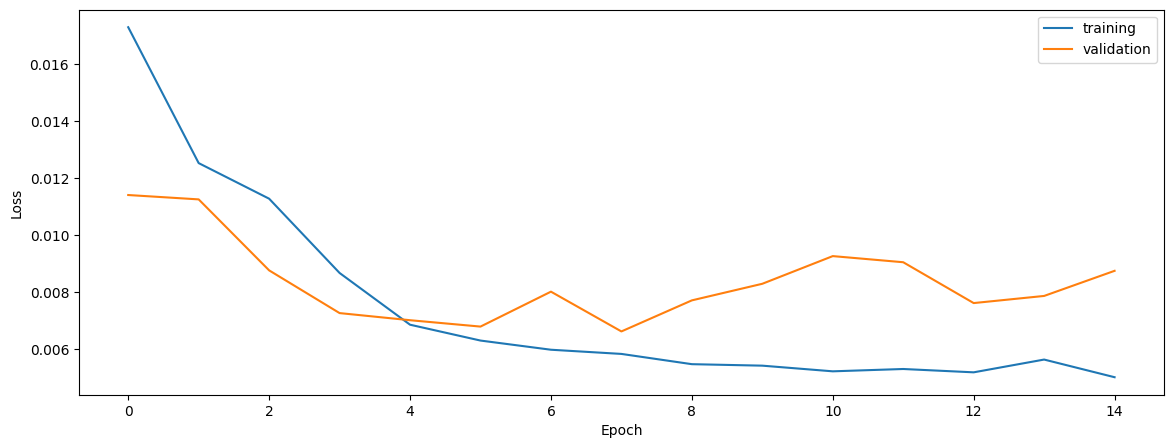

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.7503356368577045
0.6672446891279842
0.7290900495436358


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.7503356368577045
0.6672446891279842
0.7290900495436358


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.7525278493297197
0.6813995988011833
0.7139716368324037


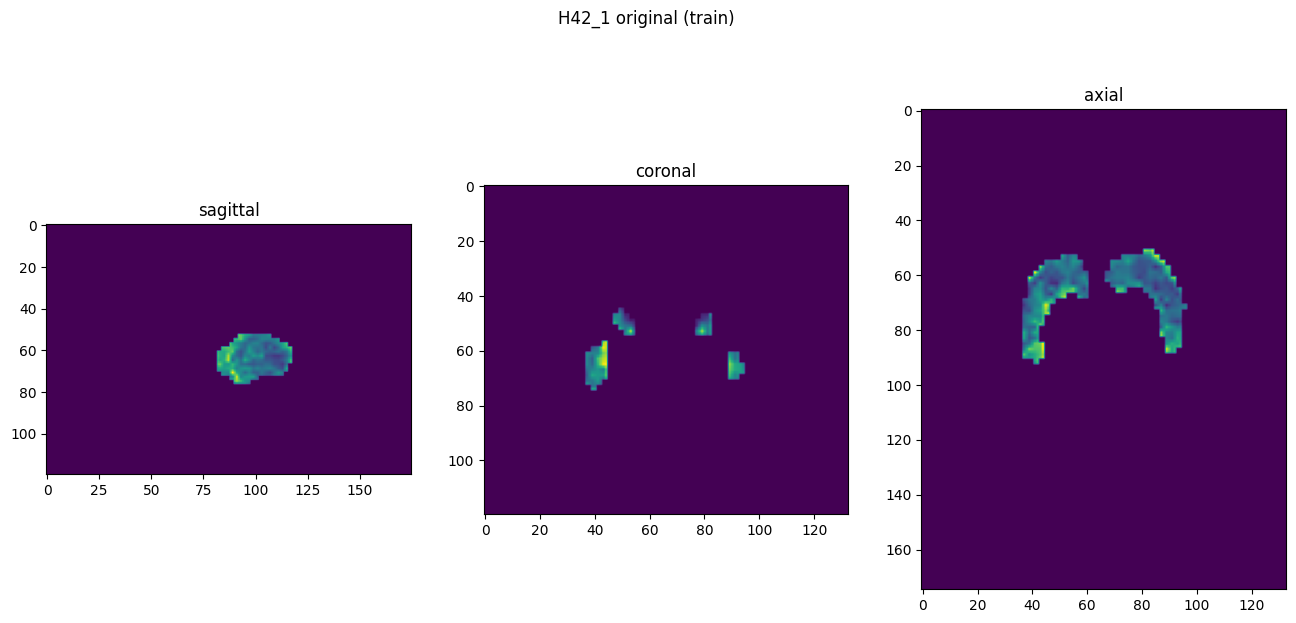

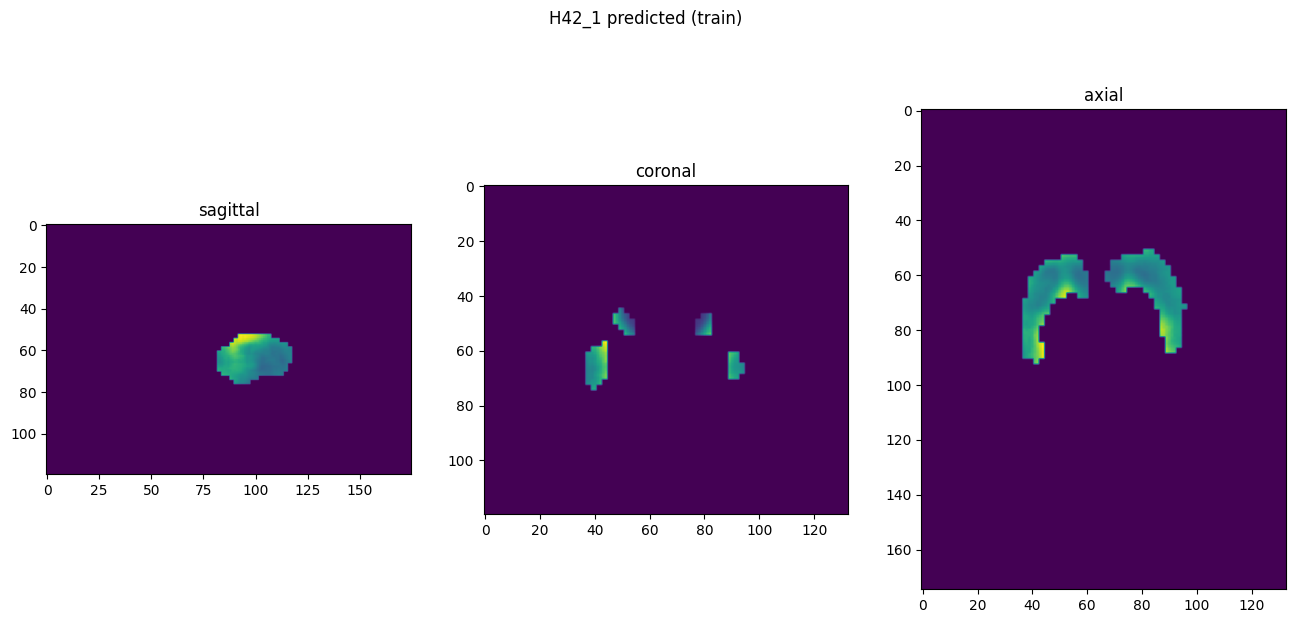

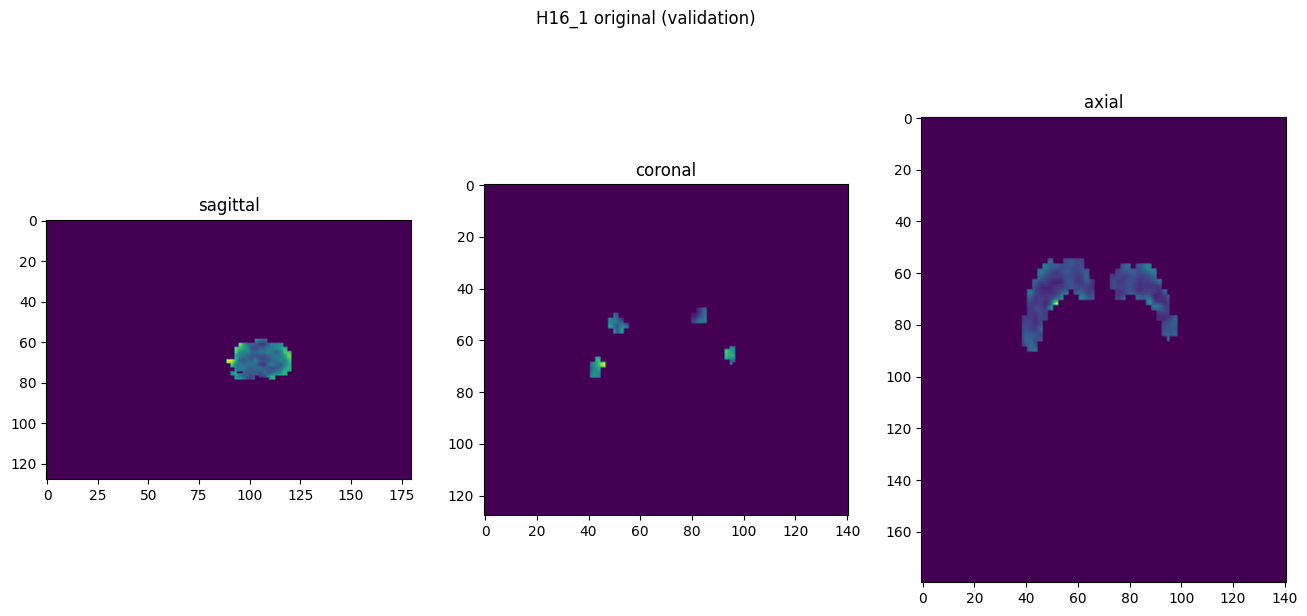

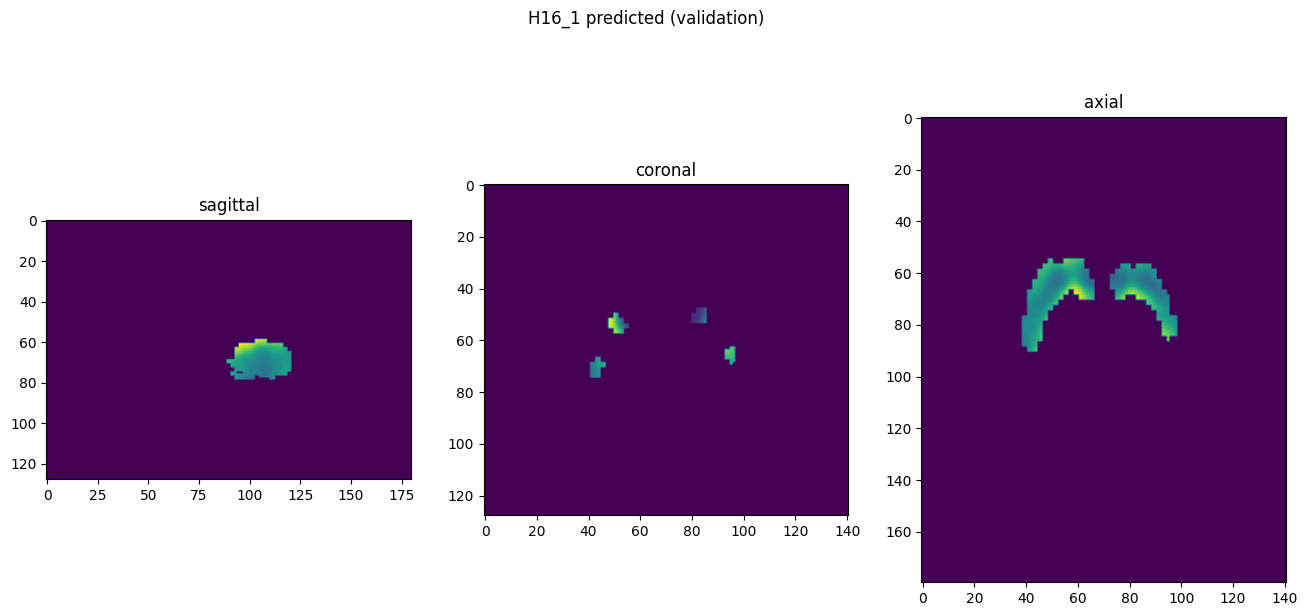

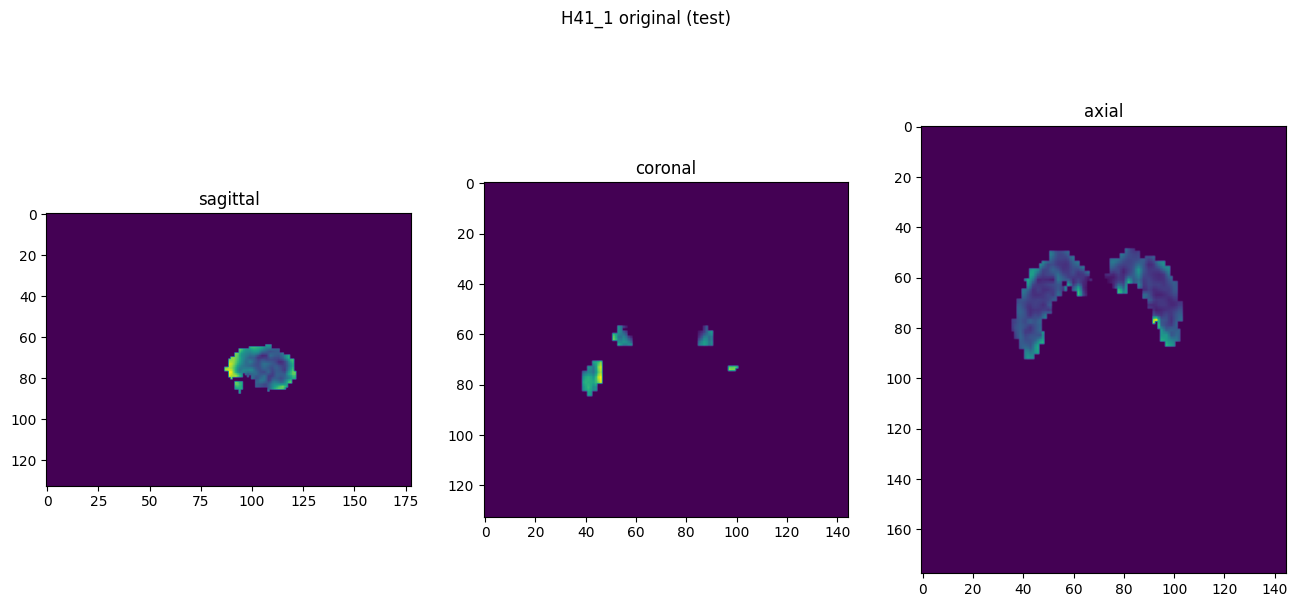

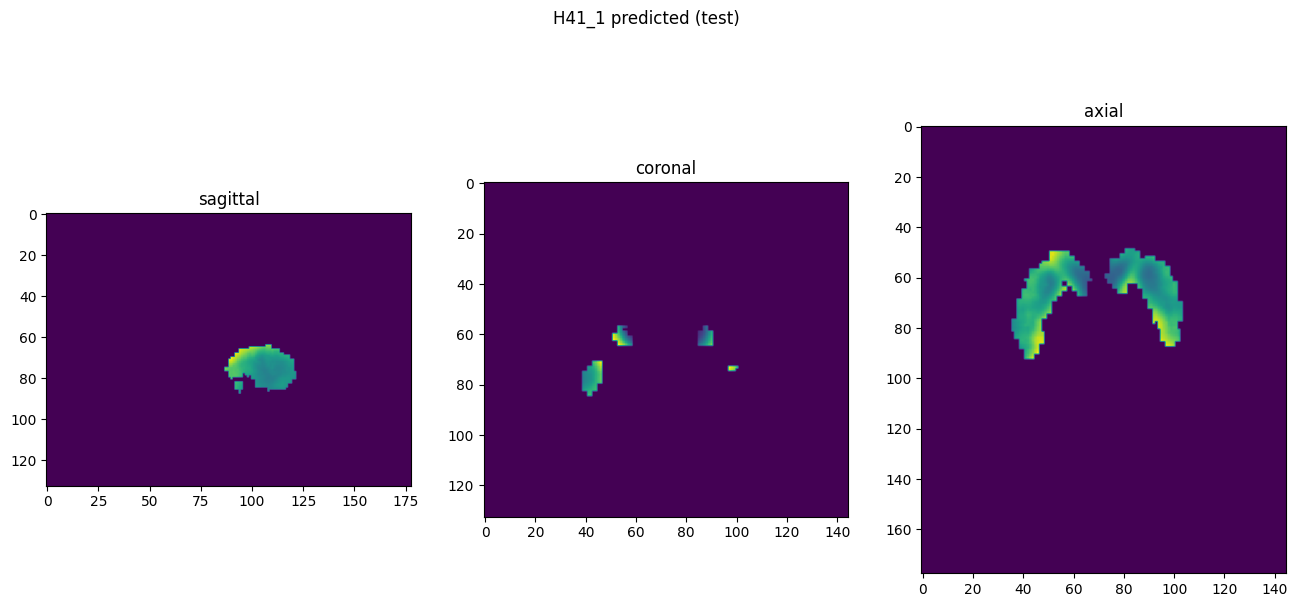

In [10]:
showResults(model, gen, threshold=None, background=False)